In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
img_idx=8
img=cv2.imread('../../data/ICDAR2015/JPGImages/%06d.jpg'%img_idx)
H = img.shape[0]
W = img.shape[1]
gt_file = open('../../data/ICDAR2015/Annotations/%06d.gt'%img_idx)
contents=gt_file.readlines()
gt = np.zeros((len(contents),8))
for i in range(len(contents)):
    box = contents[i].split()[1:]
    gt[i,:] = np.array([int(x) for x in box])

In [3]:
def _get_matrix(H, W, newH, newW, new_cx, new_cy):
    # random data augmentation
    angle = 15 * (np.random.rand()*2.0-1.0) * np.pi / 180.0
    scale = 1.0 + (np.random.rand()*2.0-1.0)*0.2
    c_x = W / 2.0
    c_y = H / 2.0
    alpha = scale * np.cos(angle)
    beta = scale * np.sin(angle)
    center_x = (1-alpha)*c_x - beta*c_y
    center_y = beta*c_x + (1-alpha)*c_y
    print newW/2.0, newH/2.0
    M = np.array([[alpha, beta, center_x - new_cx + newH/2.0],
                 [-beta, alpha, center_y - new_cy + newH/2.0]])
    return M

def _trans_gt(M, gt_boxes,H,W):
    new_gt_list = []
    for n in range(len(gt_boxes)):
        new_gt = np.zeros((8,))
        for i in range(4):
            new_gt[2*i:2*i+2]=np.dot(M,np.hstack([gt_boxes[n,2*i:2*i+2],1]))
        #new_gt validation, whole new_gt out of image, then exclude it
        if new_gt[[0,2,4,6]].max() < 0 or new_gt[[1,3,5,7]].max() < 0 \
           or new_gt[[0,2,4,6]].min() > W or new_gt[[1,3,5,7]].min() > H:
            continue
        #new_gt validation, part of new_gt box goes out of image, then ignore
        if new_gt.min() < 0 or new_gt[[0,2,4,6]].max() > W or new_gt[[1,3,5,7]].max() > H:
            continue #return np.array([])
        new_gt_list.append(new_gt)
    return np.array(new_gt_list)

def circum_box(vertex_one):
    x_min = 9999; x_max = -9999; y_min = 9999; y_max = -9999;
    for i in range(0, 8, 2):
        if vertex_one[i] < x_min:
            x_min = vertex_one[i];
        elif vertex_one[i] > x_max :
            x_max = vertex_one[i];
        if vertex_one[i + 1] < y_min:
            y_min = vertex_one[i + 1];
        elif vertex_one[i + 1] > y_max:
            y_max = vertex_one[i + 1];
    return np.array([x_min, x_max, y_min, y_max])

def _augment_data(img, gt_boxes):
    H = img.shape[0]
    W = img.shape[1]
    newH=newW=512
    
    circ_boxes=[circum_box(bbox) for bbox in gt_boxes]
    for try_idx in range(100):
        bbox=circ_boxes[np.random.choice(len(circ_boxes),1)[0]]
        cx,cy=(np.mean(bbox[[0,1]]),np.mean(bbox[[2,3]]))
        M = _get_matrix(H, W, newH, newW,cx,cy)
        new_gt = _trans_gt(M, gt_boxes,newH,newW)
        if len(new_gt)>0:
            break
    #apply affine transformation
    newImg = cv2.warpAffine(img, M, (newW, newH))
    return newImg, new_gt


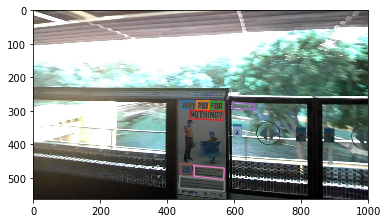

In [4]:
plt.imshow(img)
for i in range(len(gt)):
    plt.plot(gt[i,[0,2,4,6,0]], gt[i,[1,3,5,7,1]])
def warpCoords(gt, M):
    new_gt_boxes = []
    for n in range(len(gt)):
        new_gt = np.zeros((8,))
        for i in range(4):
            new_gt[2*i:2*i+2]=np.dot(M,np.hstack([gt[n,2*i:2*i+2],1]))
        new_gt_boxes.append(new_gt)
    return np.array(new_gt_boxes)

256.0 256.0
(8, 8)


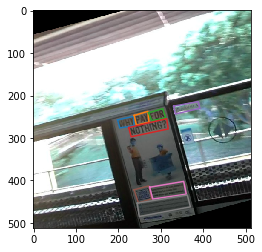

In [5]:
newImg, new_gt = _augment_data(img, gt)
print new_gt.shape
plt.imshow(newImg)
for i in range(len(new_gt)):
    plt.plot(new_gt[i,[0,2,4,6,0]], new_gt[i,[1,3,5,7,1]])